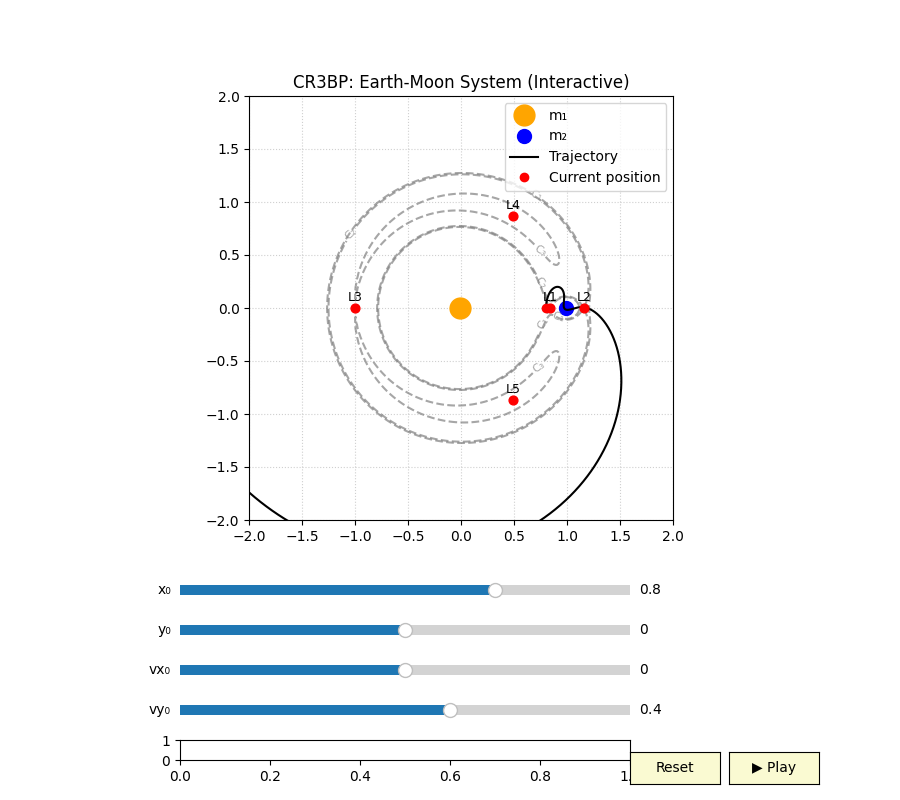

In [3]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import matplotlib.animation as animation

from cr3bp.jacobi_const import omega
from const.const import mu_earth_moon
from cr3bp.collinear import collinear_lagrange_points
from numeric.integrate import integrate_cr3bp

# ----------------------------
# Parameters
# ----------------------------
mu = mu_earth_moon #0.01215  # Earth-Moon
t_max = 8.0
n_steps = 1500

# ----------------------------
# Compute Lagrange Points
# ----------------------------

L1, L2, L3 = collinear_lagrange_points(mu)
L4 = (0.5 - mu, np.sqrt(3)/2)
L5 = (0.5 - mu, -np.sqrt(3)/2)


C_L1 = 2 * omega(L1, 0, mu)
C_L2 = 2 * omega(L2, 0, mu)
C_L3 = 2 * omega(L3, 0, mu)


# ----------------------------
# Jacobi Contour Grid
# ----------------------------
xg = np.linspace(-2, 2, 300)
yg = np.linspace(-2, 2, 300)
Xg, Yg = np.meshgrid(xg, yg)
Omega_grid = omega(Xg, Yg, mu)
C_grid = 2 * Omega_grid

# ----------------------------
# Initial Setup
# ----------------------------
z0_default = [0.8, 0.0, 0.0, 0.4]
traj = integrate_cr3bp(z0_default, mu, t_max, n_steps)

# ----------------------------
# Plot
# ----------------------------
fig, ax = plt.subplots(figsize=(9, 8))
plt.subplots_adjust(bottom=0.35)

# Contours
contour_levels = [C_L3, C_L2, C_L1]
contours = ax.contour(Xg, Yg, C_grid, levels=contour_levels, colors='gray', linestyles='--', alpha=0.7)
ax.clabel(contours, fmt={C_L3: 'C₃', C_L2: 'C₂', C_L1: 'C₁'}, fontsize=8)

# Primaries
ax.plot(-mu, 0, 'o', color='orange', markersize=15, label='m₁')
ax.plot(1 - mu, 0, 'o', color='blue', markersize=10, label='m₂')

# Lagrange points
Lx = [L1, L2, L3, L4[0], L5[0]]
Ly = [0, 0, 0, L4[1], L5[1]]
L_labels = ['L1', 'L2', 'L3', 'L4', 'L5']
ax.scatter(Lx, Ly, color='red', s=40, zorder=5)
for i, txt in enumerate(L_labels):
    ax.annotate(txt, (Lx[i], Ly[i]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=9)

# Trajectory
traj_line, = ax.plot(traj[:,0], traj[:,1], 'k-', lw=1.5, label='Trajectory')
particle, = ax.plot([], [], 'ro', markersize=6, label='Current position')

ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.grid(True, linestyle=':', alpha=0.6)
ax.legend(loc='upper right')
ax.set_title('CR3BP: Earth-Moon System (Interactive)')

# ----------------------------
# Sliders
# ----------------------------
slider_ax = plt.axes([0.2, 0.25 - i*0.05, 0.5, 0.025])  # reused in loop
slider_color = 'lightgoldenrodyellow'
sliders = {}
params = [('x₀', -2, 2, z0_default[0]),
          ('y₀', -2, 2, z0_default[1]),
          ('vx₀', -2, 2, z0_default[2]),
          ('vy₀', -2, 2, z0_default[3])]

for i, (name, vmin, vmax, val) in enumerate(params):
    ax_s = plt.axes([0.2, 0.25 - i*0.05, 0.5, 0.025], facecolor=slider_color)
    sliders[name] = Slider(ax_s, name, vmin, vmax, valinit=val)

# ----------------------------
# Animation control
# ----------------------------
anim = None
anim_running = False

def integrate_and_update():
    z0 = [sliders['x₀'].val, sliders['y₀'].val, sliders['vx₀'].val, sliders['vy₀'].val]
    global traj
    traj = integrate_cr3bp(z0, mu, t_max, n_steps)
    traj_line.set_data(traj[:,0], traj[:,1])
    particle.set_data([], [])
    return z0

def update_plot(frame):
    if frame < len(traj):
        particle.set_data([traj[frame,0]], [traj[frame,1]])
    return particle,

def start_animation(event):
    global anim, anim_running
    if anim_running:
        anim.event_source.stop()
        button_anim.label.set_text('▶ Play')
    else:
        integrate_and_update()
        anim = animation.FuncAnimation(fig, update_plot, frames=len(traj), interval=20, blit=True, repeat=True)
        button_anim.label.set_text('⏸ Pause')
    anim_running = not anim_running
    plt.draw()

# Reset button
def reset(event):
    for s in sliders.values():
        s.reset()
    integrate_and_update()
    particle.set_data([], [])
    fig.canvas.draw_idle()

ax_reset = plt.axes([0.7, 0.02, 0.1, 0.04])
button_reset = Button(ax_reset, 'Reset', color=slider_color)
button_reset.on_clicked(reset)

# Play/Pause button
ax_anim = plt.axes([0.81, 0.02, 0.1, 0.04])
button_anim = Button(ax_anim, '▶ Play', color=slider_color)
button_anim.on_clicked(start_animation)

# Slider update
def on_slider_change(val):
    integrate_and_update()
    if not anim_running:
        particle.set_data([traj[0,0]], [traj[0,1]])
    fig.canvas.draw_idle()

for s in sliders.values():
    s.on_changed(on_slider_change)

# Initial particle position
particle.set_data([traj[0,0]], [traj[0,1]])

plt.show()